# import thư viện

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# load dữ liệu

In [2]:
from sklearn import datasets

In [3]:
iris = datasets.load_iris()

In [6]:
X = iris.data
y = iris.target

In [7]:
X.shape, y.shape

((150, 4), (150,))

In [9]:
np.unique(y)

array([0, 1, 2])

# features selection and data preprocessing (standardization scaling)

## feature selection

In [23]:
# lấy 2 lớp cho bài toán phân loại 2 lớp
X = X[ (y == 0) | (y == 1) ]
y = y[ (y == 0) | (y == 1) ]
# lấy 2 features 2 và 3 để trực quan trên biểu đồ 2 chiều
X = X[:, [2, 3]]

In [24]:
X.shape, y.shape

((100, 2), (100,))

## train test split

In [25]:
from sklearn.model_selection import train_test_split

In [26]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.3,
                                                   random_state=1,
                                                   stratify=y)

In [27]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((70, 2), (70,), (30, 2), (30,))

In [29]:
'number per label in y, y_train, y_test', np.bincount(y), np.bincount(y_train), np.bincount(y_test)

('number per label in y, y_train, y_test',
 array([50, 50], dtype=int64),
 array([35, 35], dtype=int64),
 array([15, 15], dtype=int64))

## feature scaling

In [30]:
from sklearn.preprocessing import StandardScaler

In [32]:
sc = StandardScaler()
sc.fit(X_train)
X_train_std = sc.transform(X_train)
X_test_std = sc.transform(X_test)

In [33]:
X_test_std.mean(), X_test_std.std()

(0.0038983374940011317, 0.9900261542677267)

# define logistic regression object

In [65]:
class LogisticFBGD:
    def __init__(self, eta=0.1, n_iter=20, random_state=1):
        self.eta = eta
        self.n_iter = n_iter
        self.random_state = random_state
    def fit(self, X, y):
        self._initialize_weights(X.shape[1])
        self.losses_ = list() 
        for _ in range(self.n_iter):
            losses = self.update_weights(X, y)
            avg_loss = losses.mean()
            self.losses_.append(avg_loss)
    def update_weights(self, X, y):
        net_input = self.net_input(X)
        caculated_output = self.activation(net_input)
        errors = (y - caculated_output)
        self.w_ += self.eta * X.T.dot(errors) / y.shape[0]
        self.b_ += errors.mean()
        losses = -y.dot(np.log(caculated_output)) - (1 - y).dot(np.log(1 - caculated_output))
        return losses
        
    def _initialize_weights(self, d):
        rgen = np.random.RandomState(self.random_state)
        self.w_ = rgen.normal(loc=0.0, scale=0.01, size=d)
        self.b_ = np.float_(0.0)
        self.initialized_weights_ = True
    def net_input(self, X):
        return X.dot(self.w_) + self.b_
    def activation(self, z):
        return 1 / (1 + np.exp(np.clip(-z, -250, 250)))
    def predict(self, X):
        net_input = self.net_input(X)
        caculated_output = self.activation(net_input)
        return np.where(caculated_output >= 0.5, 1, 0)

# training

In [66]:
logreg = LogisticFBGD()
logreg.fit(X_train_std, y_train)

# evaluate

## classification accuracy

In [67]:
(logreg.predict(X_test_std) == y_test).sum() / y_test.shape[0]

1.0

## error 

In [68]:
(logreg.predict(X_test_std) != y_test).sum() / y_test.shape[0]

0.0

## from sklearn metrics

In [69]:
from sklearn.metrics import accuracy_score

In [70]:
y_predict = logreg.predict(X_test_std)
accuracy_score(y_test, y_predict)

1.0

# visualization

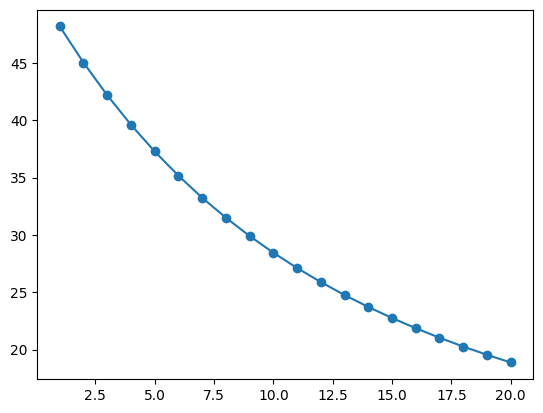

In [74]:
losses = logreg.losses_
plt.plot(range(1, len(losses) + 1), losses, marker='o')

In [75]:
from matplotlib.colors import ListedColormap
def plot_desicion_boundary(X, y, classifier, test_idx):
    colors = ('red', 'blue', 'green', 'black')
    cmap = ListedColormap(colors[0:len(np.unique(y))])
    markers = ['o', 's', '^', '<']
    resolution = 0.02
    x1_min, x1_max = X[:, 0].min(), X[:, 0].max()
    x2_min, x2_max = X[:, 1].min(), X[:, 1].max()
    xx1, xx2 = np.meshgrid(np.arange(x1_min - 1, x1_max + 1, resolution),
                            np.arange(x2_min - 1, x2_max + 1, resolution))
    labels = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    labels = labels.reshape(xx1.shape)
    plt.contourf(xx1, xx2, labels, cmap=cmap, alpha=0.2)

    for idx, class_ in enumerate(np.unique(y)):
        plt.scatter(X[y == class_, 0], X[y == class_, 1], color = colors[idx],
                    marker = markers[idx],
                   edgecolor='black')
    if test_idx:
        plt.scatter(X[test_idx, 0], X[test_idx, 1],
                    color='none',
                    edgecolor='black',
                    alpha=1.0,
                    linewidth=1,
                   marker='o',
                    s=100,
                    label='test set'
                   )

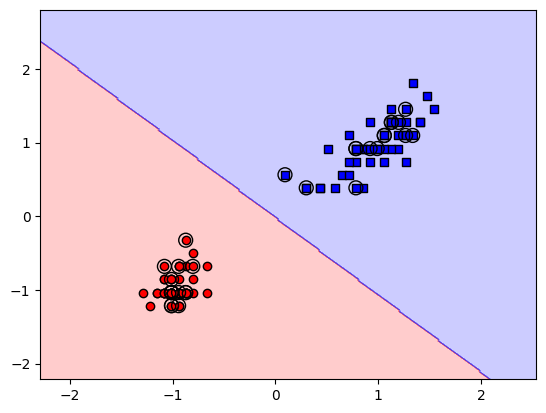

In [84]:
X_combined = np.vstack((X_train_std, X_test_std))
y_combined = np.hstack((y_train, y_test))
plot_desicion_boundary(X_combined, y_combined, logreg, range(70, 100))

# logistic regression with stochatics gradient descent

In [101]:
class LogisticSGD:
    def __init__(self, eta=0.1, n_iter=20, random_state=1):
        self.eta = eta
        self.n_iter = n_iter
        self.random_state = random_state
    def fit(self, X, y):
        self._initialize_weights(X.shape[1])
        self.losses_ = list() 
        for _ in range(self.n_iter):
            losses = list()
            for i in range(X.shape[0]):    
                loss = self.update_weights(X, y)
                losses.append(loss)
            avg_loss = np.mean(losses)
            self.losses_.append(avg_loss)
    def update_weights(self, X, y):
        net_input = self.net_input(X)
        caculated_output = self.activation(net_input)
        error = (y - caculated_output)
        self.w_ += self.eta * X.T.dot(error)
        self.b_ += self.eta * error
        loss = -y.dot(np.log(caculated_output)) - (1 - y).dot(np.log(1 - caculated_output))
        return loss
        
    def _initialize_weights(self, d):
        rgen = np.random.RandomState(self.random_state)
        self.w_ = rgen.normal(loc=0.0, scale=0.01, size=d)
        self.b_ = np.float_(0.0)
        self.initialized_weights_ = True
    def net_input(self, X):
        return X.dot(self.w_) + self.b_
    def activation(self, z):
        return 1 / (1 + np.exp(np.clip(-z, -250, 250)))
    def predict(self, X):
        net_input = self.net_input(X)
        caculated_output = self.activation(net_input)
        return np.where(caculated_output >= 0.5, 1, 0)

In [102]:
logregSGD = LogisticSGD()

In [103]:
logregSGD.fit(X = X_train_std, y = y_train)

In [104]:
y_predict = logregSGD.predict(X_test_std)

ValueError: operands could not be broadcast together with shapes (30,) (70,) 

In [107]:
logregSGD.w_, logregSGD.b_.shape

(array([6.30588264, 6.01000015]), (70,))